# IMPORTING THE LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

# LOADING THE DATASET

In [2]:
df = pd.read_json("./Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# DATA VISUALIZATION AND PREPROCESSING

In [3]:
df.isna().sum() 

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [4]:
del df['article_link'] 

In [5]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

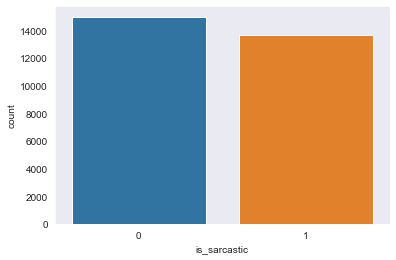

In [6]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [7]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**BASIC DATA CLEANING**

In [8]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

df['headline']=df['headline'].apply(denoise_text)

c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


**WORDCLOUD FOR TEXT THAT IS NOT SARCASTIC (LABEL - 0)**

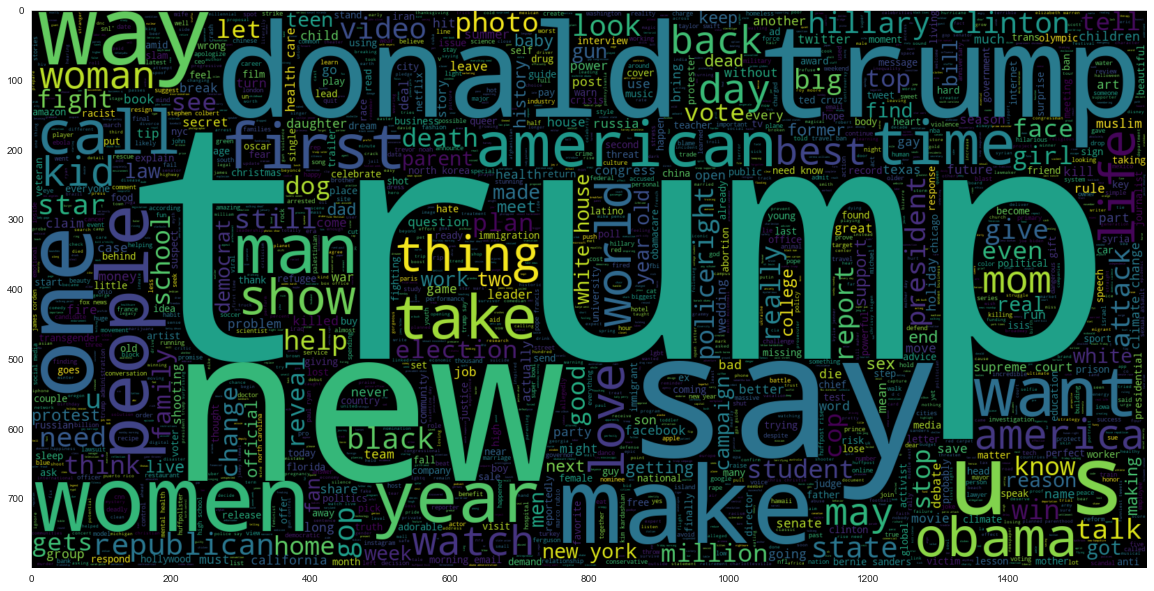

In [9]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR SARCASTIC TEXT (LABEL - 1)**

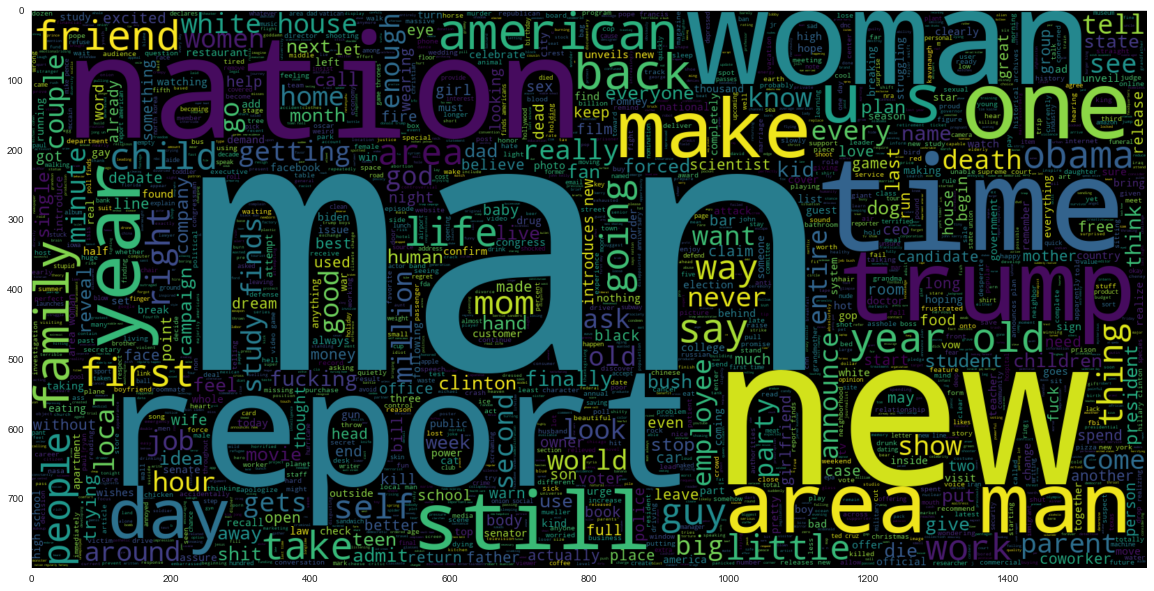

In [10]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

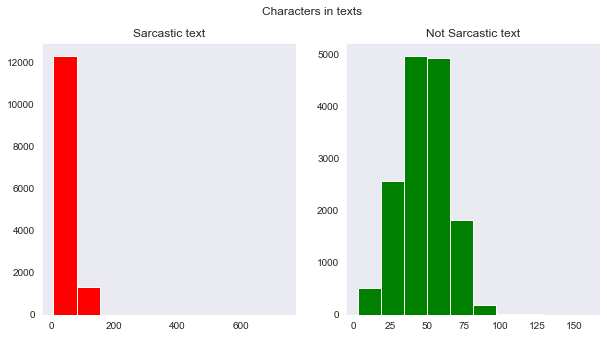

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

**Number of words in each text**

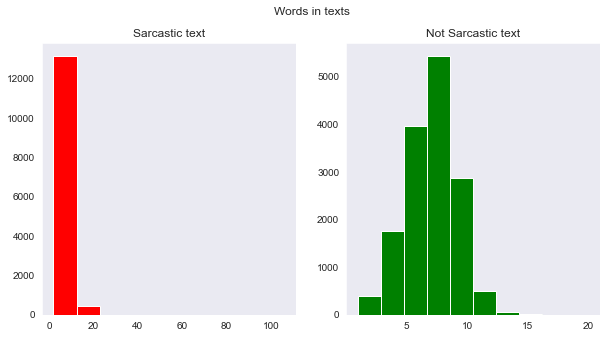

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\ayans\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

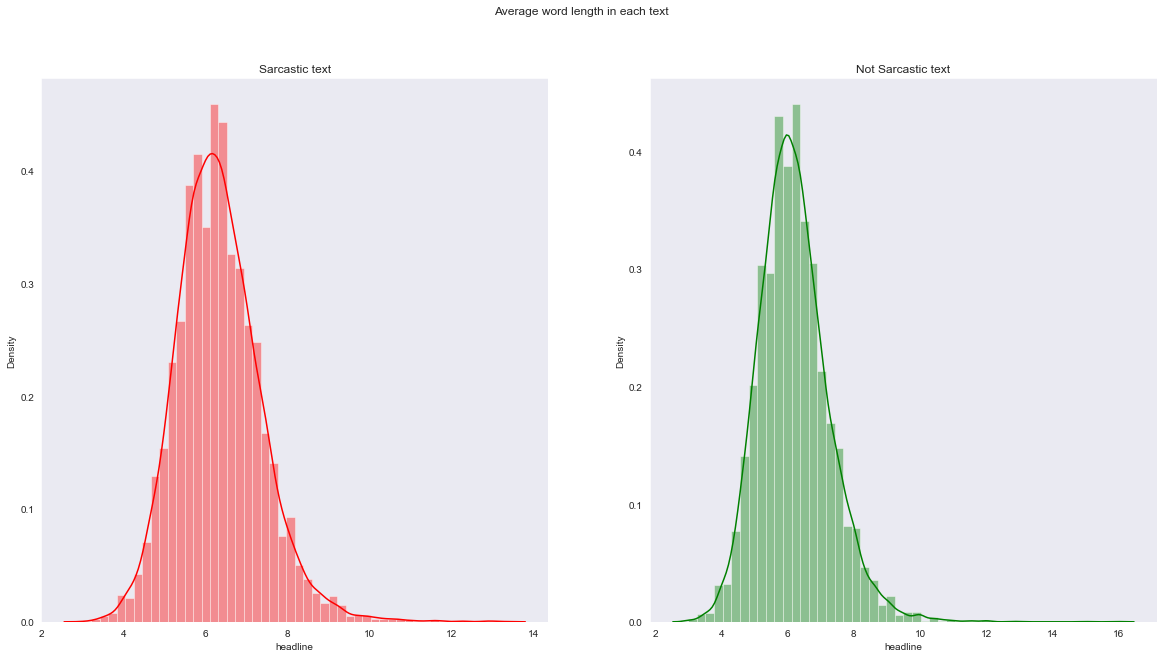

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

**Converting text to format acceptable by gensim**

In [14]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [15]:
print(df.headline.values)

['thirtysomething scientists unveil doomsday clock hair loss'
 'dem rep. totally nails congress falling short gender, racial equality'
 'eat veggies: 9 deliciously different recipes' ...
 'beautiful acceptance speech week came queer korean'
 'mars probe destroyed orbiting spielberg-gates space palace'
 'dad clarifies food stop']


In [16]:
import gensim
EMBEDDING_DIM = 200

w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [17]:
len(w2v_model.wv.key_to_index)

38071

In [18]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [19]:
vocab_size = len(tokenizer.word_index) + 1

In [20]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [21]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

# TRAINING WORD2VEC MODEL

In [22]:
from keras.layers import Embedding
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])
del embedding_vectors

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           7614400   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


In [24]:
print(x)

[[    0     0     0 ...  2336   558   944]
 [    0     0     0 ... 11455  1990  1810]
 [    0     0     0 ... 16794   480  1357]
 ...
 [    0     0     0 ...   957   671  1654]
 [    0     0     0 ...  3001   825  5968]
 [    0     0     0 ...  2970   171    88]]


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [26]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
157/157 [==============================] - 45s 238ms/step - loss: 0.5223 - acc: 0.7247 - val_loss: 0.4188 - val_acc: 0.8075
Epoch 2/3
157/157 [==============================] - 37s 238ms/step - loss: 0.1543 - acc: 0.9422 - val_loss: 0.4690 - val_acc: 0.8006
Epoch 3/3
157/157 [==============================] - 37s 238ms/step - loss: 0.0408 - acc: 0.9868 - val_loss: 0.7571 - val_acc: 0.7940


In [27]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 7s 11ms/step - loss: 0.0121 - acc: 0.9971
Accuracy of the model on Training Data is -  99.71047639846802
269/269 [==============================] - 3s 11ms/step - loss: 0.7571 - acc: 0.7940
Accuracy of the model on Testing Data is -  79.39669489860535


In [28]:
import os.path
if os.path.isfile('models/trained_model.h5') is False:
    model.save('models/trained_model.h5')

In [29]:
from tensorflow.keras.models import load_model
saved_model = load_model('models/trained_model.h5')

In [30]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           7614400   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


# PREDICTION USING TRAINED MODEL 

In [31]:
print(x_test)

[[    0     0     0 ...    40   395  2349]
 [    0     0     0 ...  5263  2448  3404]
 [    0     0     0 ...  9031  7954   831]
 ...
 [    0     0     0 ...   375  2043 17578]
 [    0     0     0 ...  5263  7529 28756]
 [    0     0     0 ...  1026   158   108]]


In [32]:
pred = (model.predict(x_test) > 0.5).astype("int32")
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]])

In [33]:
cm = confusion_matrix(y_test,pred)
cm

array([[3678,  882],
       [ 887, 3139]], dtype=int64)

<AxesSubplot:>

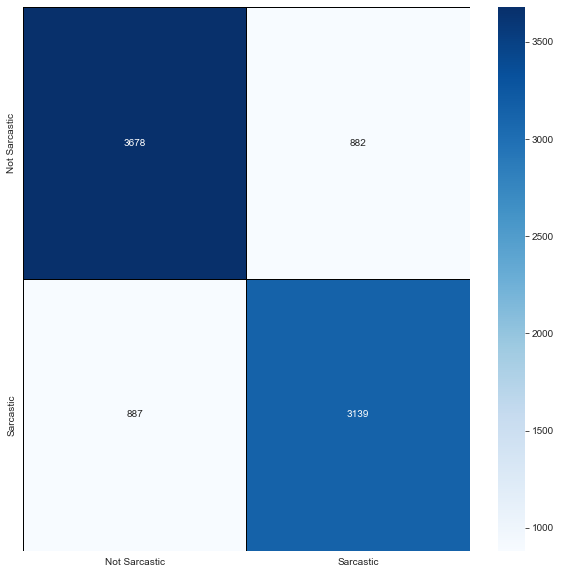

In [34]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])